## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
reduce_lr_factor = [0.5,0.7,0.9]
redice_lr_patient =[5,10,15] 

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience= reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0726 19:01:44.881799  5528 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 19:01:44.882800  5528 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 19:01:44.884799  5528 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 19:01:44.939800  5528 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0726 19:01:45.129799  5528 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0726 19:01:45.135800  5528 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0726 19:01:45.199800  5528 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 85us/step - loss: 1.2015 - acc: 0.5846 - val_loss: 1.4682 - val_acc: 0.4810
Epoch 15/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1777 - acc: 0.5937 - val_loss: 1.4726 - val_acc: 0.4816
Epoch 16/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1551 - acc: 0.6042 - val_loss: 1.4621 - val_acc: 0.4877
Epoch 17/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1326 - acc: 0.6099 - val_loss: 1.4617 - val_acc: 0.4844
Epoch 18/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1085 - acc: 0.6197 - val_loss: 1.4566 - val_acc: 0.4915
Epoch 19/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.0866 - acc: 0.6282 - val_loss: 1.4636 - val_acc: 0.4893
Epoch 20/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.0659 - acc: 0.6358 - val_loss: 1.4553 - val_acc: 0.4954
Epoch 21/25
50000/50000 [=====================

50000/50000 [==============================] - 5s 100us/step - loss: 2.2109 - acc: 0.2721 - val_loss: 2.1015 - val_acc: 0.3090
Epoch 2/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.7421 - acc: 0.3949 - val_loss: 1.7941 - val_acc: 0.3815
Epoch 3/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.6149 - acc: 0.4369 - val_loss: 1.6782 - val_acc: 0.4107
Epoch 4/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5403 - acc: 0.4601 - val_loss: 1.6324 - val_acc: 0.4233
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4847 - acc: 0.4800 - val_loss: 1.6051 - val_acc: 0.4350
Epoch 6/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4398 - acc: 0.4962 - val_loss: 1.5738 - val_acc: 0.4443
Epoch 7/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4009 - acc: 0.5120 - val_loss: 1.5600 - val_acc: 0.4476
Epoch 8/25
50000/50000 [===========================

50000/50000 [==============================] - 5s 93us/step - loss: 0.9767 - acc: 0.6713 - val_loss: 1.4638 - val_acc: 0.4980
Epoch 25/25
50000/50000 [==============================] - 5s 107us/step - loss: 0.9565 - acc: 0.6782 - val_loss: 1.4561 - val_acc: 0.4945
Numbers of exp: 5, reduce_factor: 0.70, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.2580 - acc: 0.5656 - val_loss: 1.4865 - val_acc: 0.4790
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.2330 - acc: 0.5742 - val_loss: 1.4836 - val_acc: 0.4798
Epoch 14/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.2100 - acc: 0.5827 - val_loss: 1.4761 - val_acc: 0.4836
Epoch 15/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1871 - acc: 0.5916 - val_loss: 1.4701 - val_acc: 0.4904
Epoch 16/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.1629 - acc: 0.5999 - val_loss: 1.4787 - val_acc: 0.4837
Epoch 17/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.1414 - acc: 0.6088 - val_loss: 1.4753 - val_acc: 0.4854
Epoch 18/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1187 - acc: 0.6159 - val_loss: 1.4594 - val_acc: 0.4905
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 106us/step - loss: 2.2754 - acc: 0.2584 - val_loss: 2.1463 - val_acc: 0.2978
Epoch 2/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.7495 - acc: 0.3893 - val_loss: 1.8240 - val_acc: 0.3719
Epoch 3/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.6248 - acc: 0.4323 - val_loss: 1.7035 - val_acc: 0.4013
Epoch 4/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.5510 - acc: 0.4568 - val_loss: 1.6484 - val_acc: 0.4166
Epoch 5/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.4971 - acc: 0.4767 - val_loss: 1.6028 - val_acc: 0.4286
Epoch 6/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.4498 - acc: 0.4926 - val_loss: 1.5887 - val_acc: 0.4383
Epoch 7/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.4107 - acc: 0.5066 - val_loss: 1.5571 - val_ac

Epoch 23/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.5124 - acc: 0.8424 - val_loss: 1.5621 - val_acc: 0.5096
Epoch 24/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.4867 - acc: 0.8512 - val_loss: 1.6097 - val_acc: 0.5029

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.4338 - acc: 0.8763 - val_loss: 1.5399 - val_acc: 0.5219
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)      

50000/50000 [==============================] - 5s 103us/step - loss: 1.1373 - acc: 0.6074 - val_loss: 1.4557 - val_acc: 0.4835
Epoch 10/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1053 - acc: 0.6205 - val_loss: 1.4532 - val_acc: 0.4852
Epoch 11/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.0722 - acc: 0.6334 - val_loss: 1.4706 - val_acc: 0.4809
Epoch 12/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.0436 - acc: 0.6459 - val_loss: 1.4474 - val_acc: 0.4937
Epoch 13/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.0173 - acc: 0.6548 - val_loss: 1.4464 - val_acc: 0.4906
Epoch 14/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.9915 - acc: 0.6635 - val_loss: 1.4211 - val_acc: 0.5008
Epoch 15/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.9672 - acc: 0.6729 - val_loss: 1.4299 - val_acc: 0.4978
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.9225 - acc: 0.3491 - val_loss: 1.8633 - val_acc: 0.3719
Epoch 2/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.5885 - acc: 0.4457 - val_loss: 1.7096 - val_acc: 0.3996
Epoch 3/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.4936 - acc: 0.4783 - val_loss: 1.6218 - val_acc: 0.4337
Epoch 4/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.4287 - acc: 0.5020 - val_loss: 1.5524 - val_acc: 0.4525
Epoch 5/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.3774 - acc: 0.5225 - val_loss: 1.5516 - val_acc: 0.4609
Epoch 6/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.3356 - acc: 0.5374 - val_loss: 1.5094 - val_acc: 0.4669
Epoch 7/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.2968 - acc: 0.5517 - val_loss: 1.4902 - 

Epoch 24/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.9529 - acc: 0.6849 - val_loss: 1.4664 - val_acc: 0.4908
Epoch 25/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.9374 - acc: 0.6918 - val_loss: 1.4490 - val_acc: 0.4964
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

Epoch 11/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1968 - acc: 0.5890 - val_loss: 1.4838 - val_acc: 0.4790
Epoch 12/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1746 - acc: 0.5992 - val_loss: 1.4782 - val_acc: 0.4848
Epoch 13/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1542 - acc: 0.6066 - val_loss: 1.4648 - val_acc: 0.4855
Epoch 14/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1328 - acc: 0.6148 - val_loss: 1.4544 - val_acc: 0.4926
Epoch 15/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1134 - acc: 0.6231 - val_loss: 1.4600 - val_acc: 0.4940
Epoch 16/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.0962 - acc: 0.6289 - val_loss: 1.4661 - val_acc: 0.4900
Epoch 17/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.0796 - acc: 0.6356 - val_loss: 1.4554 - val_acc: 0.4897
Epoch 18/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.8130 - acc: 0.3715 - val_loss: 2.2573 - val_acc: 0.2682
Epoch 2/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.5430 - acc: 0.4575 - val_loss: 2.3759 - val_acc: 0.2482
Epoch 3/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.4383 - acc: 0.4928 - val_loss: 2.0952 - val_acc: 0.2944
Epoch 4/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.3591 - acc: 0.5208 - val_loss: 2.4642 - val_acc: 0.2658
Epoch 5/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.3073 - acc: 0.5379 - val_loss: 2.2093 - val_acc: 0.2953
Epoch 6/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2560 - acc: 0.5570 - val_loss: 2.8339 - val_acc: 0.2158
Epoch 7/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2103 - acc: 0.5727 - val_loss: 2.0823 - val_ac

50000/50000 [==============================] - 5s 94us/step - loss: 0.6511 - acc: 0.7965 - val_loss: 1.5656 - val_acc: 0.4850
Epoch 23/25
50000/50000 [==============================] - 5s 96us/step - loss: 0.6291 - acc: 0.8032 - val_loss: 1.6128 - val_acc: 0.4709
Epoch 24/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.6097 - acc: 0.8100 - val_loss: 1.6050 - val_acc: 0.4943
Epoch 25/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.5867 - acc: 0.8209 - val_loss: 1.5497 - val_acc: 0.4987
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batc

50000/50000 [==============================] - 5s 95us/step - loss: 1.1647 - acc: 0.5978 - val_loss: 1.5707 - val_acc: 0.4536
Epoch 10/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.1249 - acc: 0.6145 - val_loss: 1.6215 - val_acc: 0.4472
Epoch 11/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.0917 - acc: 0.6277 - val_loss: 1.6037 - val_acc: 0.4432
Epoch 12/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.0564 - acc: 0.6420 - val_loss: 1.5734 - val_acc: 0.4652
Epoch 13/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.0235 - acc: 0.6516 - val_loss: 1.6688 - val_acc: 0.4356
Epoch 14/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.9948 - acc: 0.6629 - val_loss: 1.6720 - val_acc: 0.4365

Epoch 00014: ReduceLROnPlateau reducing learning rate to 8.750000415602699e-05.
Epoch 15/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.9313 - acc: 0.6889 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 150us/step - loss: 2.1297 - acc: 0.2901 - val_loss: 2.1034 - val_acc: 0.3217
Epoch 2/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.7725 - acc: 0.3873 - val_loss: 1.8286 - val_acc: 0.3765
Epoch 3/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.6471 - acc: 0.4260 - val_loss: 1.7293 - val_acc: 0.4046
Epoch 4/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.5655 - acc: 0.4540 - val_loss: 1.6977 - val_acc: 0.4089
Epoch 5/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.5035 - acc: 0.4752 - val_loss: 1.6495 - val_acc: 0.4208
Epoch 6/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.4525 - acc: 0.4943 - val_loss: 1.6155 - val_acc: 0.4387
Epoch 7/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.4088 - acc: 0.5091 - val_loss: 1.5923 - v

50000/50000 [==============================] - 5s 100us/step - loss: 1.0082 - acc: 0.6666 - val_loss: 1.4926 - val_acc: 0.4891
Epoch 24/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.9914 - acc: 0.6722 - val_loss: 1.4971 - val_acc: 0.4886
Epoch 25/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.9753 - acc: 0.6768 - val_loss: 1.4873 - val_acc: 0.4919
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_la

50000/50000 [==============================] - 5s 97us/step - loss: 1.3407 - acc: 0.5375 - val_loss: 1.5604 - val_acc: 0.4539
Epoch 11/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.3104 - acc: 0.5492 - val_loss: 1.5572 - val_acc: 0.4613
Epoch 12/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2850 - acc: 0.5583 - val_loss: 1.5386 - val_acc: 0.4651
Epoch 13/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2584 - acc: 0.5679 - val_loss: 1.5405 - val_acc: 0.4691
Epoch 14/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2349 - acc: 0.5782 - val_loss: 1.5120 - val_acc: 0.4718
Epoch 15/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2117 - acc: 0.5865 - val_loss: 1.4974 - val_acc: 0.4810
Epoch 16/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.1885 - acc: 0.5957 - val_loss: 1.5071 - val_acc: 0.4732
Epoch 17/25
50000/50000 [==================

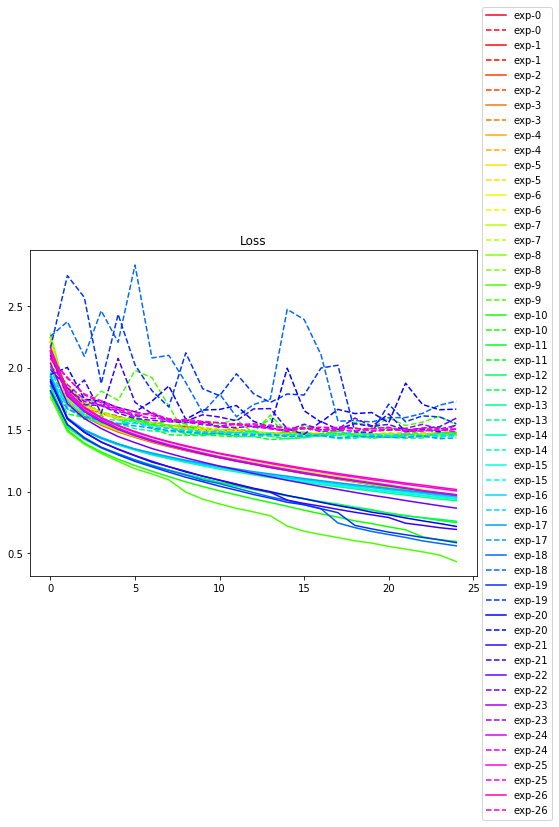

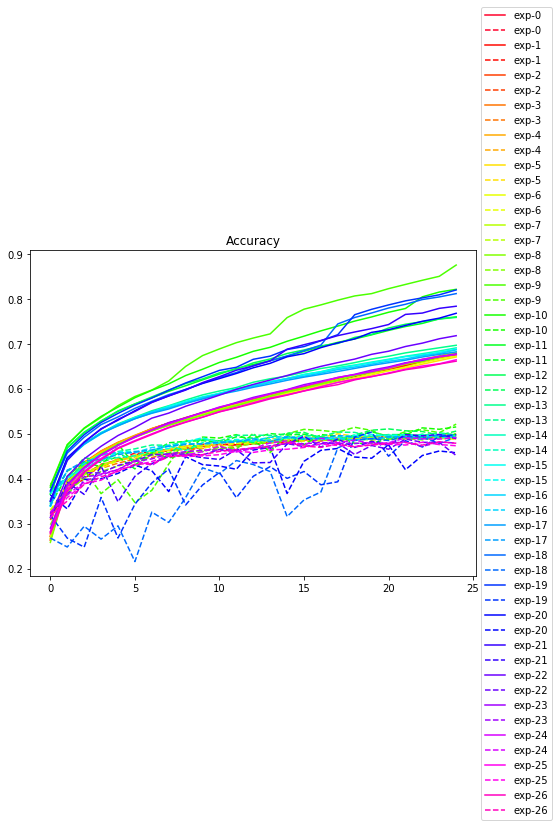

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()